In [38]:
# Data stuff
# import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedShuffleSplit
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
from joblib import dump, load

# Prepa data-set for models

In [15]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_KNN_undersample/*.part')

# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values
feature_names = dataset.drop(columns=['hospital_expire_flag']).columns.values.tolist()

# Define functions and variables

In [18]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    skf = StratifiedShuffleSplit(train_size=0.7 ,random_state = rand_state)
    
    # Search
    random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
    random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

## XGBOOST

In [20]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished


0.8279612458196283

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.796571,0.054491,0.013055,0.001812,0.8,1.25,5,25,0.1,5,1,"{'subsample': 0.8, 'scale_pos_weight': 1.25, '...",0.822163,0.832094,0.833876,0.812593,0.804262,0.832149,0.814937,0.842992,0.818353,0.830912,0.824433,0.011283,20,0.990413,0.991241,0.991233,0.991253,0.990994,0.992456,0.990955,0.991191,0.990319,0.991042,0.991110,0.000550
1,0.485403,0.030330,0.008829,0.000895,0.6,0.75,10,5,0.05,5,0.6,"{'subsample': 0.6, 'scale_pos_weight': 0.75, '...",0.825738,0.827793,0.838683,0.817196,0.808728,0.825681,0.811535,0.838986,0.818358,0.836667,0.824937,0.010387,16,0.887201,0.881723,0.884345,0.889038,0.887786,0.880581,0.884168,0.880967,0.886350,0.881201,0.884336,0.002973
2,1.135135,0.065060,0.017904,0.001426,1,1.5,5,18,0.01,0.5,0.6,"{'subsample': 1.0, 'scale_pos_weight': 1.5, 'm...",0.816752,0.824072,0.833804,0.809981,0.796885,0.822033,0.796081,0.836286,0.812777,0.825915,0.817459,0.013101,42,0.984962,0.985264,0.985564,0.983844,0.983622,0.984904,0.984173,0.986840,0.983298,0.984563,0.984704,0.000996
3,1.079346,0.040172,0.011769,0.002176,0.8,0.5,10,10,0.01,0.5,1,"{'subsample': 0.8, 'scale_pos_weight': 0.5, 'm...",0.797246,0.819474,0.827471,0.797441,0.792648,0.816182,0.789654,0.819000,0.807290,0.822502,0.808891,0.013042,48,0.873947,0.874438,0.874984,0.872547,0.876432,0.871360,0.874266,0.868700,0.873399,0.868636,0.872871,0.002464
4,1.857882,0.124468,0.021605,0.006994,0.8,1.25,5,17,0.05,5,1,"{'subsample': 0.8, 'scale_pos_weight': 1.25, '...",0.821328,0.832620,0.833504,0.817818,0.815375,0.830080,0.812805,0.839851,0.821873,0.841815,0.826707,0.009729,4,0.983026,0.980513,0.982316,0.981794,0.981105,0.980871,0.980218,0.981948,0.980833,0.981034,0.981366,0.000833
5,1.553797,0.043026,0.014715,0.001819,1,0.5,3,15,0.05,1.5,1,"{'subsample': 1.0, 'scale_pos_weight': 0.5, 'm...",0.818039,0.823262,0.830328,0.813761,0.806857,0.817510,0.810246,0.837738,0.808122,0.833284,0.819915,0.010326,39,0.996108,0.994757,0.996057,0.994847,0.994479,0.996933,0.994464,0.996186,0.995267,0.994740,0.995384,0.000824
6,0.791954,0.042050,0.013175,0.000557,0.8,0.9,3,9,0.05,2,0.6,"{'subsample': 0.8, 'scale_pos_weight': 0.9, 'm...",0.824637,0.830791,0.831105,0.816353,0.815265,0.829565,0.811918,0.848272,0.819593,0.835267,0.826276,0.010452,9,0.993839,0.992199,0.994447,0.992520,0.992285,0.992833,0.991483,0.994297,0.992272,0.992409,0.992858,0.000942
7,1.648065,0.045181,0.012123,0.000552,0.8,1.1,3,26,0.05,5,1,"{'subsample': 0.8, 'scale_pos_weight': 1.1, 'm...",0.818865,0.830678,0.835333,0.821876,0.808361,0.831375,0.811529,0.840829,0.821488,0.839041,0.825938,0.010661,11,0.984805,0.982353,0.984532,0.983515,0.982714,0.983683,0.982902,0.984123,0.981732,0.983454,0.983381,0.000920
8,0.839820,0.016250,0.012131,0.000630,0.8,0.9,5,29,0.01,1.5,0.6,"{'subsample': 0.8, 'scale_pos_weight': 0.9, 'm...",0.821780,0.824212,0.835769,0.817601,0.804538,0.823163,0.802496,0.838179,0.818689,0.833132,0.821956,0.011389,33,0.954405,0.953165,0.955305,0.952552,0.952454,0.951112,0.950793,0.953263,0.951278,0.950791,0.952512,0.001476
9,0.932635,0.015303,0.011728,0.000747,1,0.9,5,22,0.05,5,0.6,"{'subsample': 1.0, 'scale_pos_weight': 0.9, 'm...",0.826821,0.832105,0.839399,0.815444,0.808469,0.827551,0.819135,0.840583,0.815695,0.837311,0.826251,0.010639,10,0.967738,0.963536,0.968366,0.965069,0.964605,0.967229,0.964421,0.967322,0.966996,0.965573,0.966086,0.001561


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


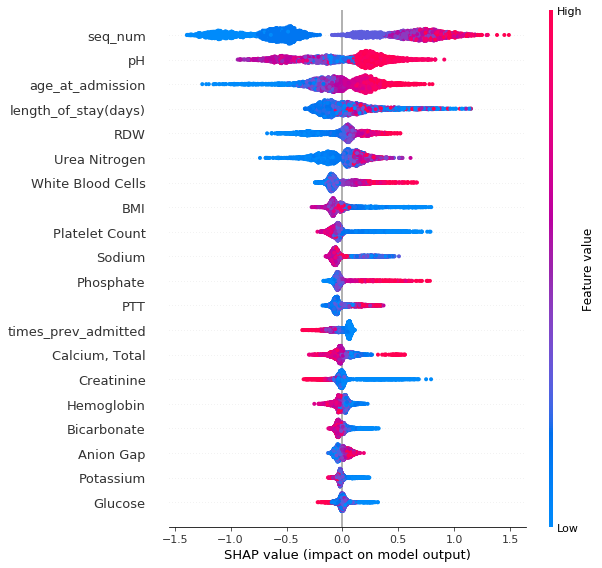

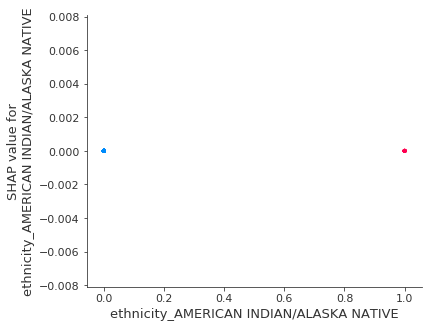

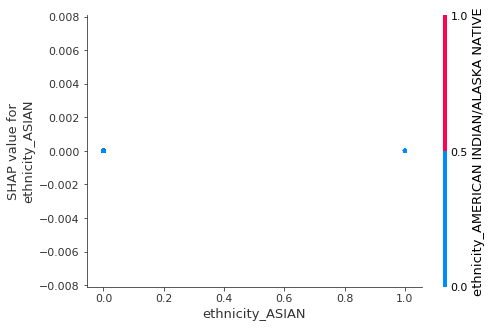

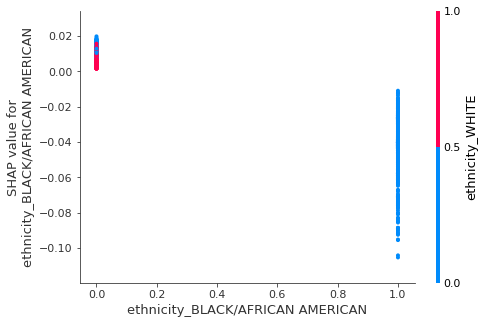

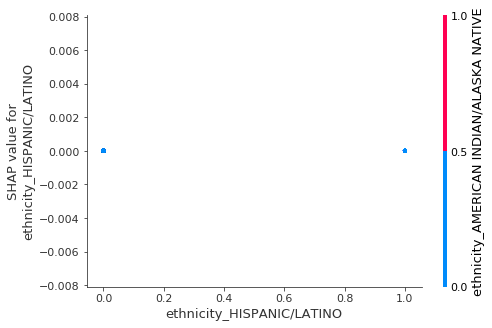

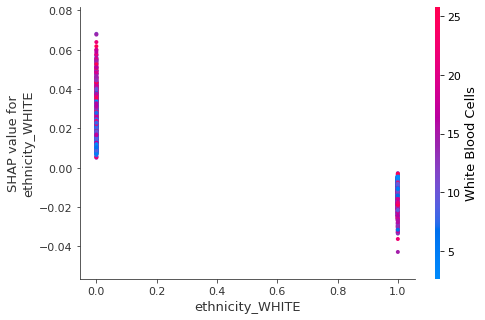

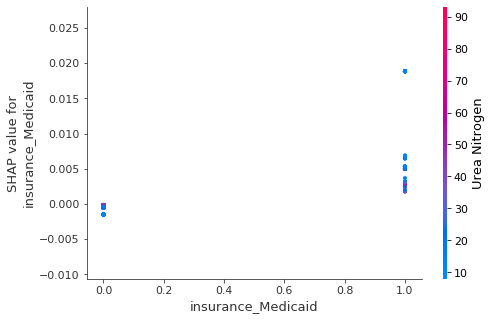

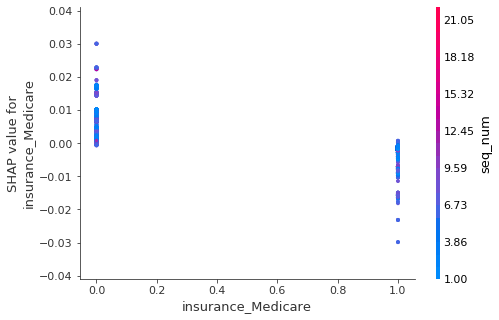

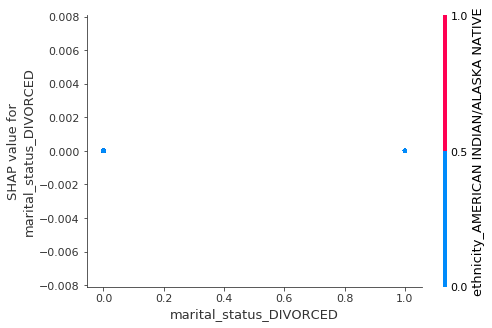

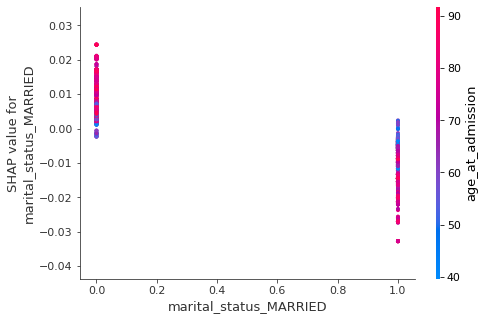

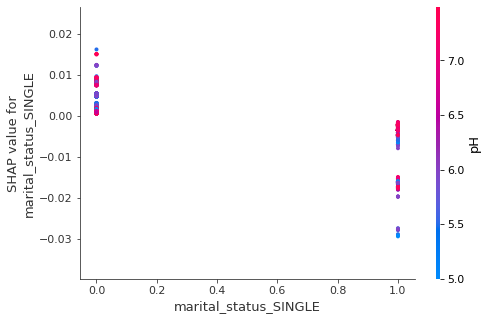

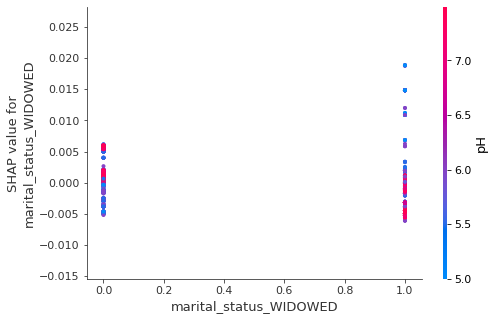

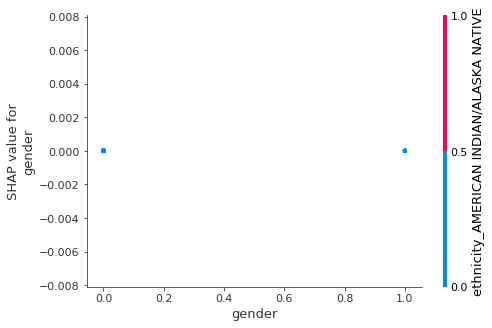

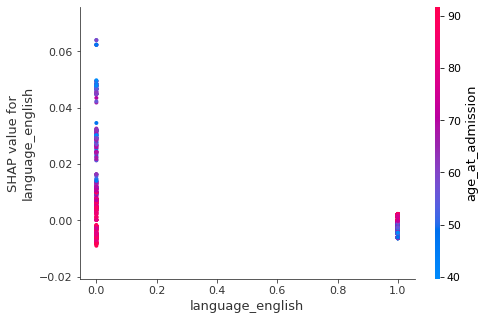

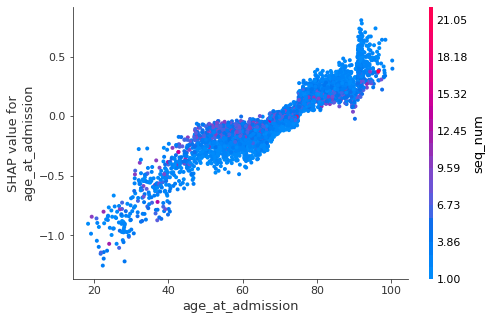

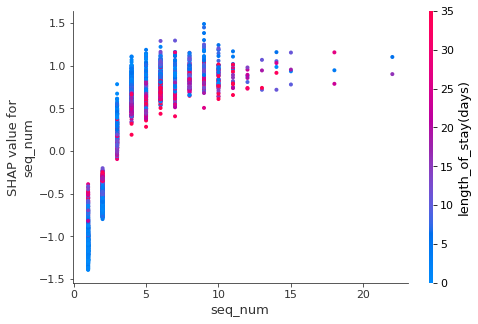

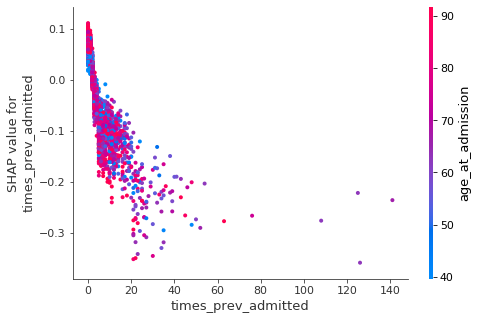

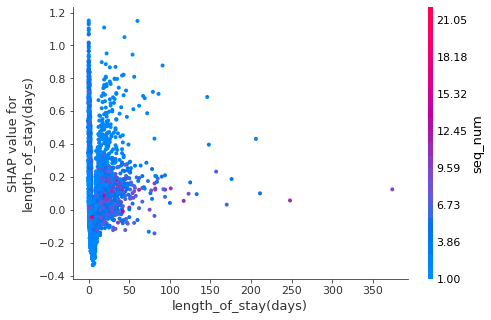

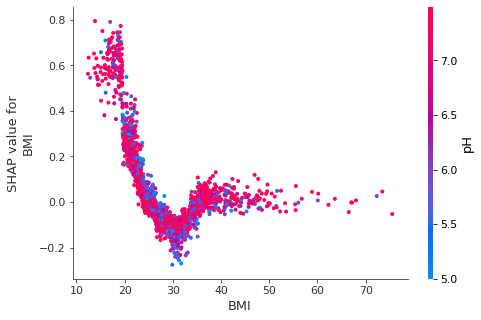

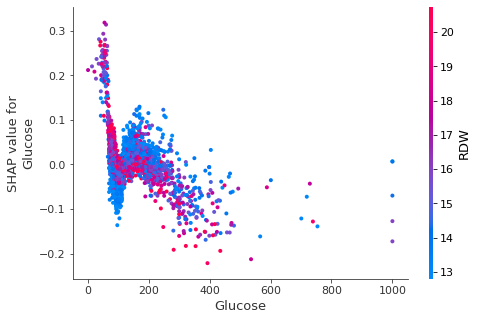

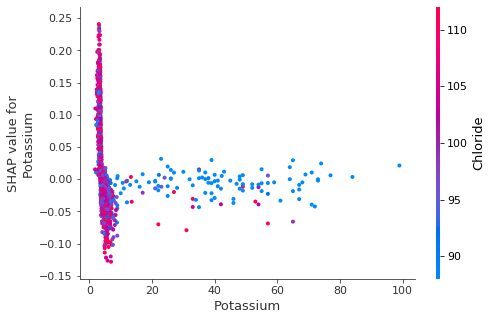

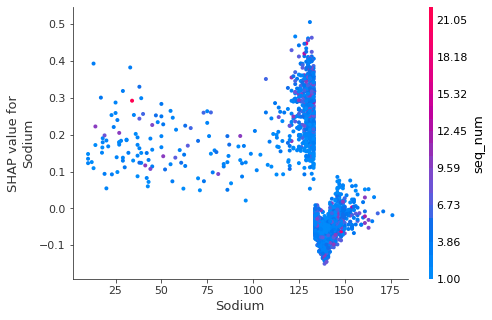

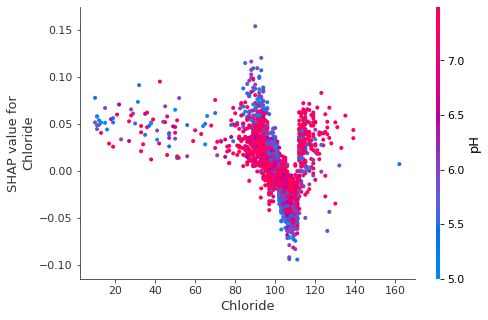

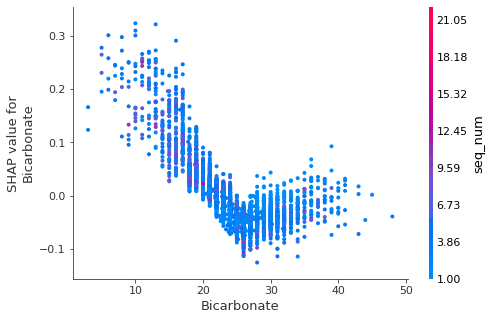

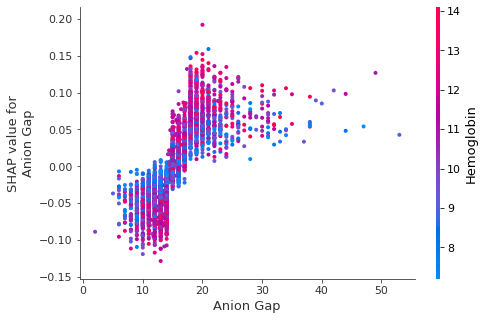

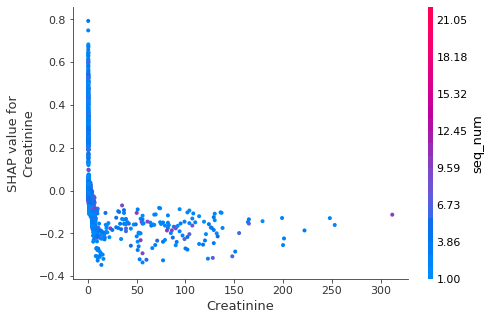

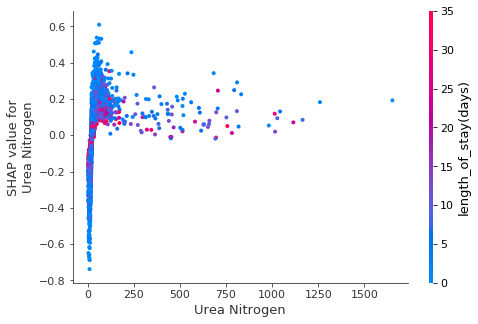

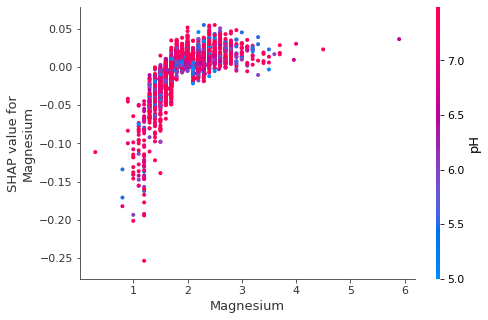

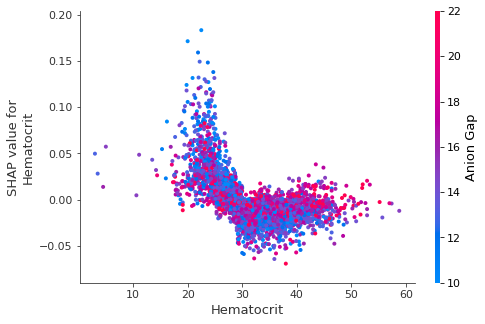

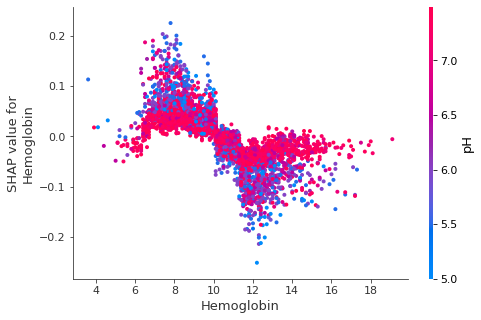

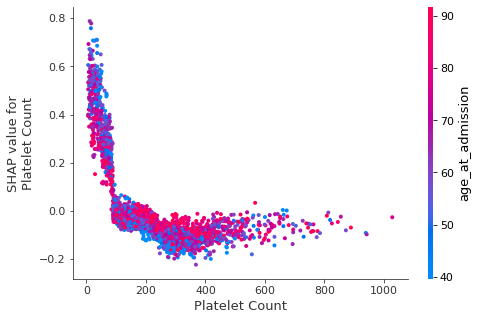

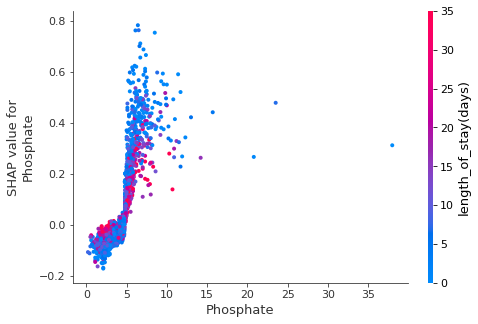

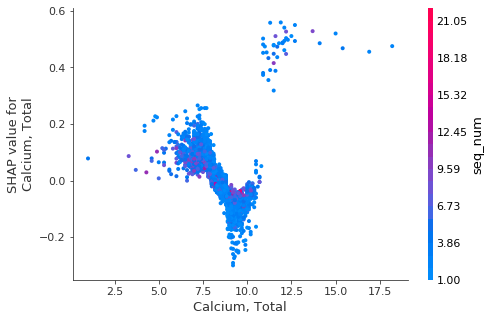

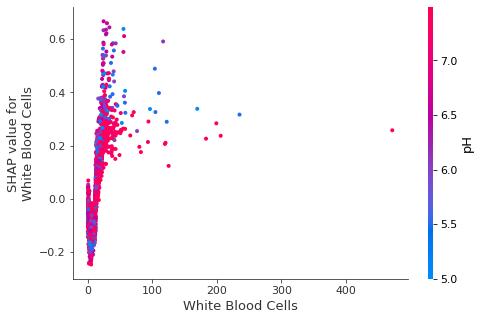

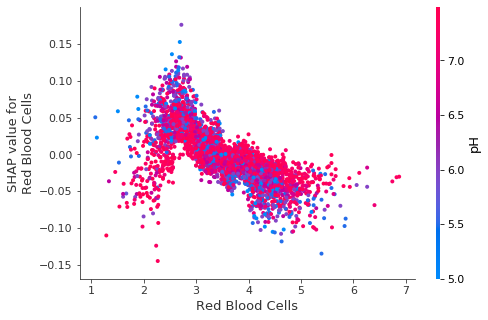

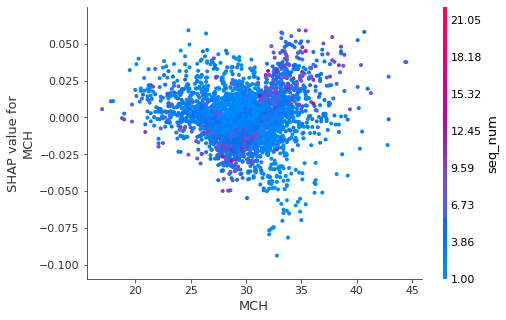

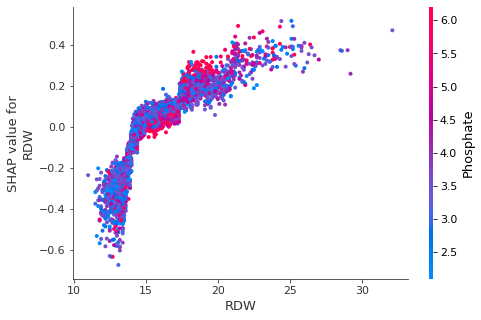

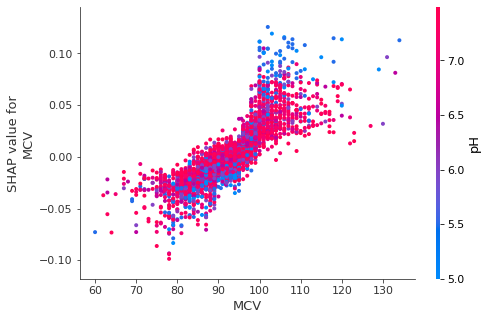

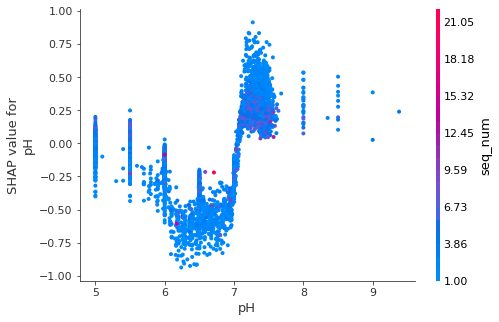

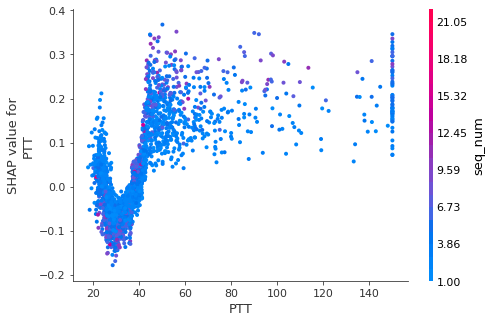

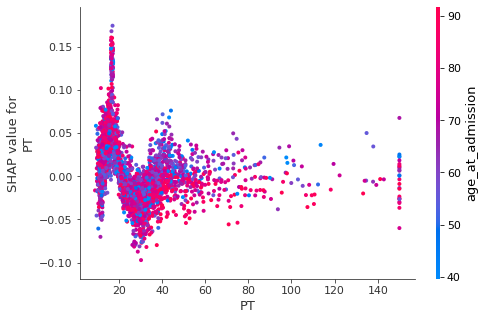

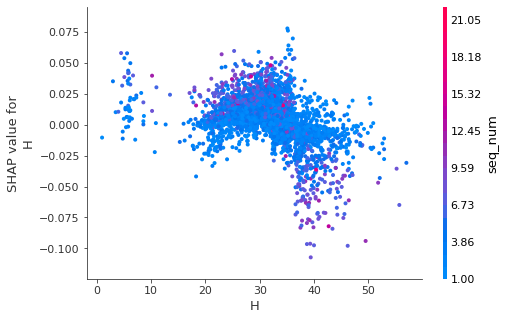

In [36]:
shap_values = explainer.shap_values( X_no_cat)
save = shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names, show=False)
plt.savefig("shap_summary.svg", format='svg', dpi=1000, bbox_inches='tight')
for predictor in feature_names:
    save = shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names, show=False)
    plt.savefig(predictor.replace(" ", "").replace("/","_")+".svg", format='svg', dpi=1000, bbox_inches='tight')

In [41]:
# dump(model, 'save.joblib') 
model = load('save.joblib') 